<a href="https://colab.research.google.com/github/NandyBa/TimeSeriePricePrediction/blob/master/SalesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
!pip install skits

In [3]:
df = pd.read_csv('Store1.csv')
df = df.drop(['Store'], axis=1)
df = df.sort_values(by='Date')
df

,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
941,2,2013-01-01,0,0,0,0,a,1
940,3,2013-01-02,5530,668,1,0,0,1
939,4,2013-01-03,4327,578,1,0,0,1
938,5,2013-01-04,4486,619,1,0,0,1
937,6,2013-01-05,4997,635,1,0,0,1
...,...,...,...,...,...,...,...,...
4,1,2015-07-27,6102,612,1,1,0,1
3,2,2015-07-28,5011,560,1,1,0,1
2,3,2015-07-29,4782,523,1,1,0,1
1,4,2015-07-30,5020,546,1,1,0,1


[]

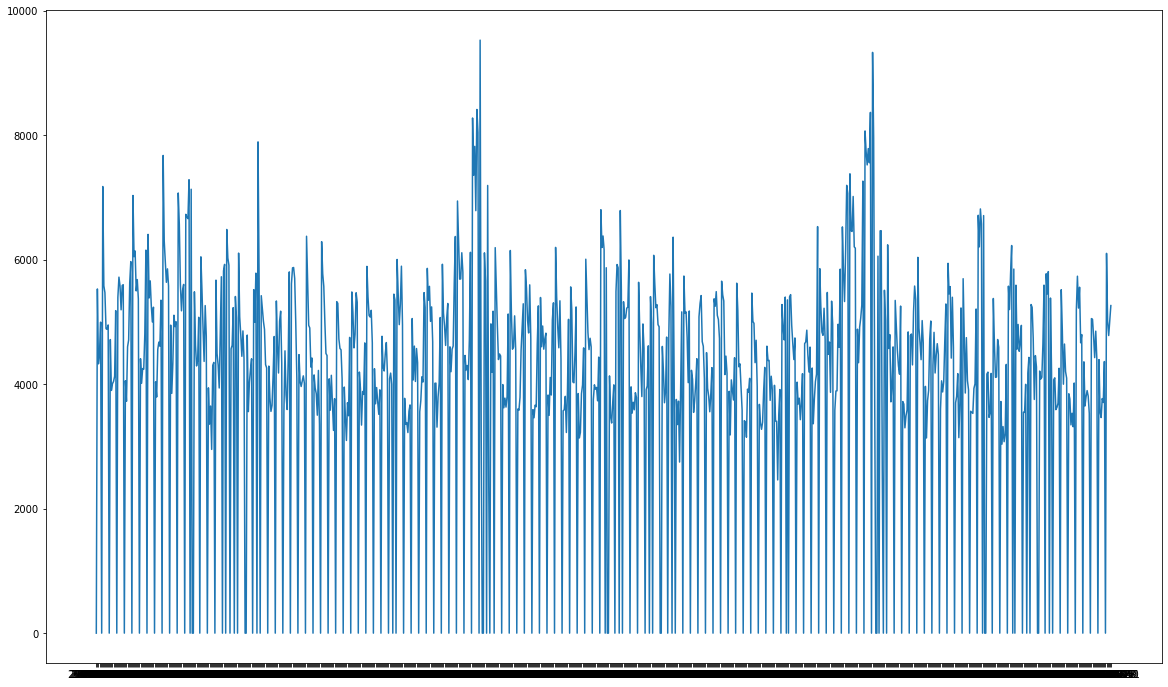

In [4]:
plt.figure(figsize=(20,12))
plt.plot(df.Date, df.Sales)
plt.plot()

In [5]:
df.StateHoliday.value_counts()

0    915
a     17
b      6
c      4
Name: StateHoliday, dtype: int64

In [6]:
print(type(df))
df.loc[df.StateHoliday.isin(['a','b','c']), 'StateHoliday'] = 1


<class 'pandas.core.frame.DataFrame'>


In [7]:
df.StateHoliday = df.StateHoliday.astype('int')

In [8]:
df.dtypes

DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday      int64
SchoolHoliday     int64
dtype: object

In [9]:
X = df.copy().drop(['Sales',"Date"], axis=1)
y = df.copy()['Sales']

In [10]:
X.shape, y.shape

((942, 6), (942,))

In [11]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(max_train_size=10, test_size=1, n_splits= 5)#942-10)
print(tscv)


for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train)




TimeSeriesSplit(gap=0, max_train_size=10, n_splits=5, test_size=1)
TRAIN: [927 928 929 930 931 932 933 934 935 936] TEST: [937]
    DayOfWeek  Customers  Open  Promo  StateHoliday  SchoolHoliday
14          5        519     1      1             0              0
13          6        512     1      0             0              0
12          7          0     0      0             0              0
11          1        526     1      0             0              0
10          2        469     1      0             0              0
9           3        463     1      0             0              0
8           4        503     1      0             0              0
7           5        459     1      0             0              0
6           6        500     1      0             0              0
5           7          0     0      0             0              0
TRAIN: [928 929 930 931 932 933 934 935 936 937] TEST: [938]
    DayOfWeek  Customers  Open  Promo  StateHoliday  SchoolHoliday
13     

In [12]:
np.concatenate( (np.array([[3,4], [4,6]]) , np.array([[5,3,6],[4,2,2]])) , axis=1 )

array([[3, 4, 5, 3, 6],
       [4, 6, 4, 2, 2]])

In [13]:
np.array([[5,3,6],[4,2,2]]).shape

(2, 3)

In [14]:
import numpy as np

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

from skits.pipeline import ForecasterPipeline
from skits.preprocessing import ReversibleImputer
from skits.feature_extraction import (AutoregressiveTransformer, 
                                      SeasonalTransformer)

def get_data(window = 14):
  df = pd.read_csv('Store1.csv')
  df.loc[df.StateHoliday.isin(['a','b','c']), 'StateHoliday'] = 1
  df = df[df.Sales != 0]

  Sales = np.array(df.Sales)
  X_features = df.copy().drop(['Sales',"Date","DayOfWeek"], axis=1)

  DayOfWeek_enc = OneHotEncoder(handle_unknown='ignore')
  DayOfWeek_enc.fit(np.array(df.DayOfWeek).reshape(-1, 1))

  X = []
  features = []
  x_days = []

  for idx in range(Sales.shape[0] - window):
    line = []
    a1 = Sales[idx: idx + window].reshape(-1,1)
    a2 = np.array([ X_features.iloc[i] for i in range(window) ])
    a3 = DayOfWeek_enc.transform(np.array(df.DayOfWeek[idx: idx + window]).reshape(-1,1)).toarray()
    X.append(
        np.concatenate((a1, a2, a3), axis=1)
    )
    #print(a1.shape, a2.shape, a3.shape)

  X = np.array(X)
  #X_days = np.array(x_days)
  y = np.array(Sales[window:])

  #X_ = X.copy()
  #X_features = np.array(features)
  #X = np.hstack((X, X_features))
  #X = np.hstack((X, X_days))
  print(X.shape)
  return X, y
X, y = get_data()

(767, 14, 13)


In [15]:
X.shape

(767, 14, 13)

In [16]:
pc_train = 0.60
pc_test = 0.2

X = np.asarray(X).astype('float32')
X_train, X_val, X_test = X[:int(len(X)*pc_train)], X[int(len(X)*pc_train):-int(len(X)*pc_test)], X[-int(len(X)*pc_test):]
y_train, y_val, y_test = y[:int(len(X)*pc_train)], y[int(len(X)*pc_train):-int(len(X)*pc_test)], y[-int(len(X)*pc_test):]

In [17]:
y.shape

(767,)

In [18]:
X_train.shape, X_val.shape, X_test.shape

((460, 14, 13), (154, 14, 13), (153, 14, 13))

In [19]:
X_test

array([[[4.149e+03, 1.000e+00, 5.550e+02, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [4.421e+03, 1.000e+00, 5.460e+02, ..., 0.000e+00, 0.000e+00,
         1.000e+00],
        [4.275e+03, 1.000e+00, 5.230e+02, ..., 0.000e+00, 1.000e+00,
         0.000e+00],
        ...,
        [4.047e+03, 1.000e+00, 5.120e+02, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [4.475e+03, 1.000e+00, 5.190e+02, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [4.090e+03, 1.000e+00, 5.170e+02, ..., 0.000e+00, 0.000e+00,
         1.000e+00]],

       [[4.421e+03, 1.000e+00, 5.550e+02, ..., 0.000e+00, 0.000e+00,
         1.000e+00],
        [4.275e+03, 1.000e+00, 5.460e+02, ..., 0.000e+00, 1.000e+00,
         0.000e+00],
        [4.904e+03, 1.000e+00, 5.230e+02, ..., 1.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [4.475e+03, 1.000e+00, 5.120e+02, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [4.090e+03, 1.000e+00, 5.190e+02, ..., 0.000e+00, 0.000e+00,
   

In [20]:
y_test

array([4986, 5701, 5875, 5868, 5614, 5804, 4407, 3593, 3827, 4536, 3549,
       4341, 5173, 5011, 4180, 4633, 5337, 4766, 4150, 3661, 3563, 3784,
       4291, 4262, 4315, 4881, 5012, 5220, 5422, 5693, 7893, 5784, 4995,
       5519, 4408, 4232, 4030, 3559, 4789, 4413, 4856, 4448, 4790, 5083,
       6106, 5064, 5409, 5230, 4624, 4568, 5912, 6027, 6486, 5925, 5821,
       5726, 4841, 3939, 4309, 4492, 5672, 4350, 4303, 2952, 3649, 3357,
       3941, 4773, 5263, 4366, 4903, 5514, 6046, 5075, 4390, 4293, 4625,
       5484, 7132, 7285, 6660, 6686, 6729, 5603, 5506, 5179, 5598, 6563,
       7072, 5003, 4925, 5108, 4341, 3853, 4949, 5578, 5853, 5637, 5973,
       6300, 7675, 5350, 4611, 4676, 4558, 3794, 4038, 5237, 5000, 5261,
       5660, 5386, 6407, 6154, 4809, 4241, 4252, 4015, 4409, 5370, 5681,
       5499, 6140, 6049, 7032, 5970, 5633, 4709, 4601, 3725, 4055, 5598,
       5586, 5195, 5578, 5720, 5394, 5182, 4127, 4044, 4008, 3900, 4717,
       4952, 4881, 4892, 5471, 5580, 7176, 4997, 44

In [44]:
learning_rate = 1e-5

inputs = keras.layers.Input(shape=(X.shape[1], X.shape[2]))
#lstm_out = keras.layers.LSTM(32)(inputs)
outputs_dense1 = keras.layers.Dense(32, activation='relu')(inputs)
outputs = keras.layers.Dense(1, activation='relu')(outputs_dense1)

model = keras.Model(inputs=inputs, outputs=outputs)
       
model.compile(
    optimizer=keras.optimizers.Adam(), #learning_rate=learning_rate),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 13)]          0         
                                                                 
 dense_8 (Dense)             (None, 14, 32)            448       
                                                                 
 dense_9 (Dense)             (None, 14, 1)             33        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [45]:
X_train.shape, y_train.shape, "    ", X_val.shape, y_val.shape

((460, 14, 13), (460,), '    ', (154, 14, 13), (154,))

In [46]:
model.fit(X_train, y_train , validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
15/15 [==============================] - 2s 33ms/step - loss: 21197454.0000 - root_mean_squared_error: 4611.3638 - val_loss: 21267632.0000 - val_root_mean_squared_error: 4620.5537
Epoch 2/100
15/15 [==============================] - 0s 6ms/step - loss: 19152892.0000 - root_mean_squared_error: 4380.5850 - val_loss: 19219736.0000 - val_root_mean_squared_error: 4392.4673
Epoch 3/100
15/15 [==============================] - 0s 6ms/step - loss: 17343200.0000 - root_mean_squared_error: 4162.7646 - val_loss: 17504184.0000 - val_root_mean_squared_error: 4191.9155
Epoch 4/100
15/15 [==============================] - 0s 9ms/step - loss: 15845039.0000 - root_mean_squared_error: 3981.0498 - val_loss: 16027522.0000 - val_root_mean_squared_error: 4011.2305
Epoch 5/100
15/15 [==============================] - 0s 10ms/step - loss: 14488184.0000 - root_mean_squared_error: 3807.5256 - val_loss: 14613753.0000 - val_root_mean_squared_error: 3830.2639
Epoch 6/100
15/15 [========================

In [47]:
y_pred = model.predict(X_test)
y_true = y_test

In [48]:
y_pred

array([[[4125.389 ],
        [4338.102 ],
        [4189.5474],
        ...,
        [3986.0703],
        [4346.9683],
        [4028.1792]],

       [[4349.5625],
        [4218.8345],
        [4707.1206],
        ...,
        [4336.9067],
        [4030.726 ],
        [4766.01  ]],

       [[4230.295 ],
        [4736.408 ],
        [4741.7095],
        ...,
        [4020.6643],
        [4768.5557],
        [5354.3223]],

       ...,

       [[5149.4644],
        [4964.0635],
        [4067.8096],
        ...,
        [5247.0405],
        [6568.678 ],
        [4774.233 ]],

       [[4975.5244],
        [4097.097 ],
        [3999.7268],
        ...,
        [6558.616 ],
        [4776.78  ],
        [4354.7344]],

       [[4108.557 ],
        [4029.0144],
        [3970.157 ],
        ...,
        [4766.7183],
        [4357.2812],
        [4224.1377]]], dtype=float32)

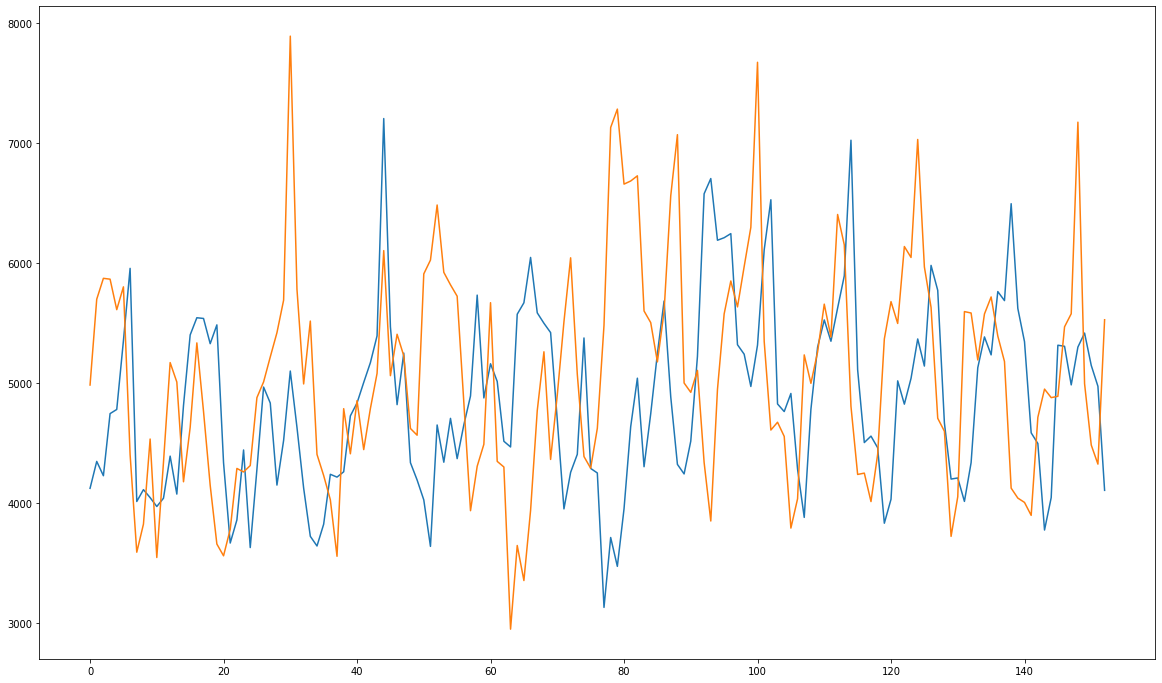

In [49]:
plt.figure(figsize=(20,12))
plt.plot([y[0] for y in y_pred])
plt.plot(y_true)

In [50]:
y_pred

array([[[4125.389 ],
        [4338.102 ],
        [4189.5474],
        ...,
        [3986.0703],
        [4346.9683],
        [4028.1792]],

       [[4349.5625],
        [4218.8345],
        [4707.1206],
        ...,
        [4336.9067],
        [4030.726 ],
        [4766.01  ]],

       [[4230.295 ],
        [4736.408 ],
        [4741.7095],
        ...,
        [4020.6643],
        [4768.5557],
        [5354.3223]],

       ...,

       [[5149.4644],
        [4964.0635],
        [4067.8096],
        ...,
        [5247.0405],
        [6568.678 ],
        [4774.233 ]],

       [[4975.5244],
        [4097.097 ],
        [3999.7268],
        ...,
        [6558.616 ],
        [4776.78  ],
        [4354.7344]],

       [[4108.557 ],
        [4029.0144],
        [3970.157 ],
        ...,
        [4766.7183],
        [4357.2812],
        [4224.1377]]], dtype=float32)

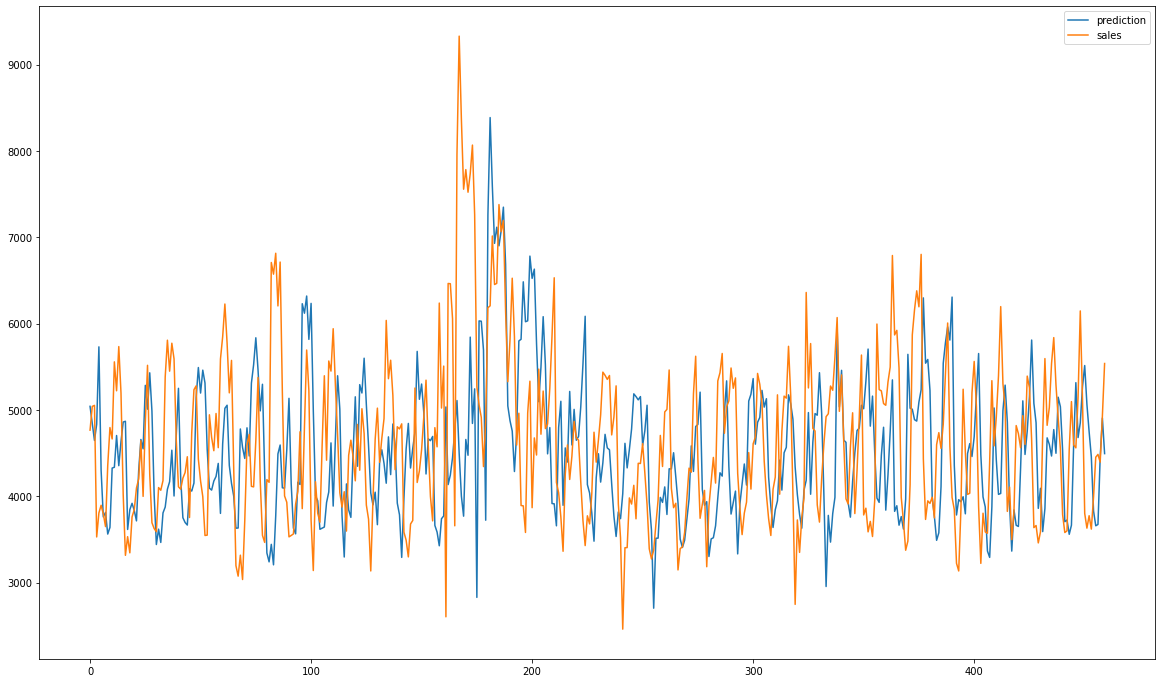

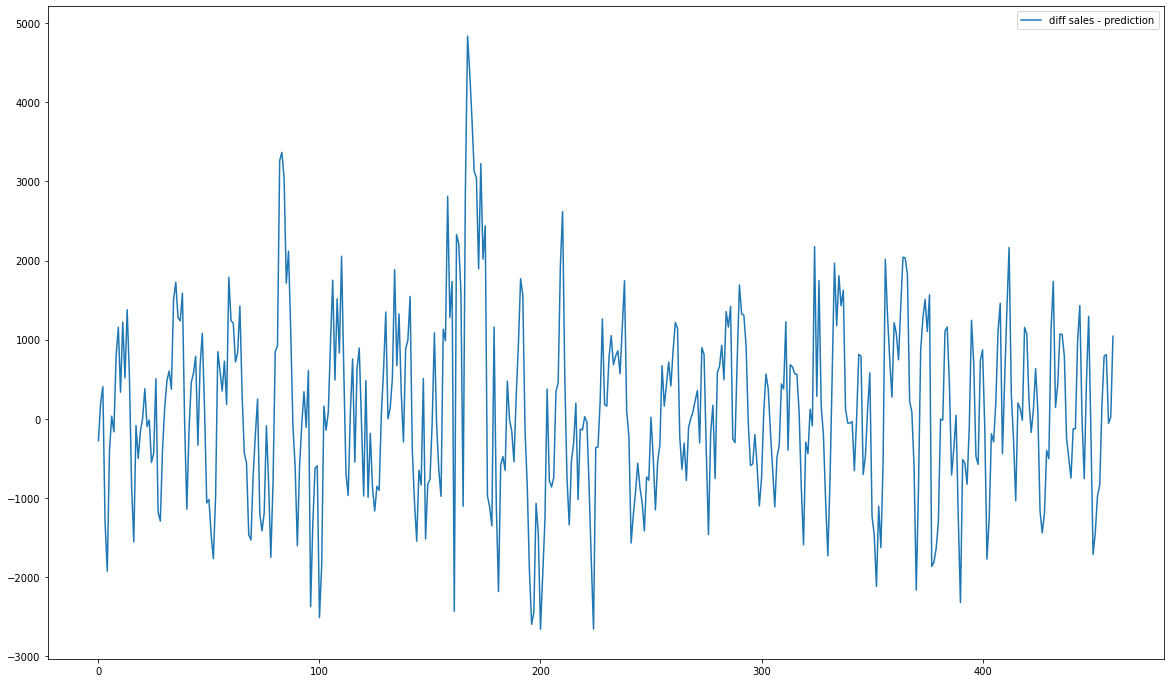

In [51]:
y_pred = model.predict(X_train)
y_true = y_train

plt.figure(figsize=(20,12))
plt.plot([y[0][0] for y in y_pred], label='prediction')
plt.plot(y_true, label='sales')
plt.legend()

plt.figure(figsize=(20,12))
plt.plot(y_true - [y[0][0] for y in y_pred], label='diff sales - prediction')
plt.legend()

In [52]:
import plotly.graph_objects as go

fig = go.Figure()

fig.update_layout(
    title_text="Prediction on the trainset",
    width=1100,
    height=700
)

fig.add_trace(go.Scatter(
    y=y_true,
    mode="lines+markers",
    name="Sales",
    textposition="top center"
))

fig.add_trace(go.Scatter(
    y=[y[0] for y in y_pred],
    mode="lines+markers",
    name="Prediction",
    textposition="top center"
))
fig.show()

# CNN Time Series Forecasting

## CNN model with 2 features

In [93]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence

pc_train = 0.60
pc_test = 0.2

in_seq1 = df.DayOfWeek[:int(pc_train*len(df))]
in_seq2 = df.Customers[:int(pc_train*len(df))]
out_seq = df.Sales[:int(pc_train*len(df))]
# convert to numpy array
in_seq1 = np.array(in_seq1)
in_seq2 = np.array(in_seq2)
out_seq = np.array(out_seq)
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))

# choose a number of time steps
n_steps = 3
# convert into input/output
X_train_, y_train_ = split_sequences(dataset, n_steps)

# Define validation set
in_seq1 = df.DayOfWeek[int(pc_train*len(df)):-int(pc_test*len(df))]
in_seq2 = df.Customers[int(pc_train*len(df)):-int(pc_test*len(df))]
out_seq = df.Sales[int(pc_train*len(df)):-int(pc_test*len(df))]
# convert to numpy array
in_seq1 = np.array(in_seq1)
in_seq2 = np.array(in_seq2)
out_seq = np.array(out_seq)
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
validationset = hstack((in_seq1, in_seq2, out_seq))

# choose a number of time steps
n_steps = 3
# convert into input/output
X_val_, y_val_ = split_sequences(dataset, n_steps)


# the dataset knows the number of features, e.g. 2
n_features = X_.shape[2]
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
# fit model
model.fit(X_train_, y_train_, validation_data=(X_val_, y_val_), epochs=200)

# Model created base on  Jason Brownlee model https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/ 

Epoch 1/200
18/18 [==============================] - 1s 24ms/step - loss: 17760768.0000 - root_mean_squared_error: 4214.3525 - val_loss: 16420875.0000 - val_root_mean_squared_error: 4052.2678
Epoch 2/200
18/18 [==============================] - 0s 9ms/step - loss: 15132982.0000 - root_mean_squared_error: 3890.1133 - val_loss: 13432239.0000 - val_root_mean_squared_error: 3665.0020
Epoch 3/200
18/18 [==============================] - 0s 9ms/step - loss: 11676946.0000 - root_mean_squared_error: 3417.1548 - val_loss: 9475337.0000 - val_root_mean_squared_error: 3078.2036
Epoch 4/200
18/18 [==============================] - 0s 9ms/step - loss: 7626641.0000 - root_mean_squared_error: 2761.6375 - val_loss: 5879902.5000 - val_root_mean_squared_error: 2424.8511
Epoch 5/200
18/18 [==============================] - 0s 9ms/step - loss: 4895733.0000 - root_mean_squared_error: 2212.6304 - val_loss: 4278621.5000 - val_root_mean_squared_error: 2068.4829
Epoch 6/200
18/18 [==============================

In [94]:
in_seq1 = df.DayOfWeek[:-int(pc_test*len(df))]
in_seq2 = df.Customers[:-int(pc_test*len(df))]
out_seq = df.Sales[:-int(pc_test*len(df))]
# convert to numpy array
in_seq1 = np.array(in_seq1)
in_seq2 = np.array(in_seq2)
out_seq = np.array(out_seq)
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
x_input = hstack((in_seq1, in_seq2, out_seq))
#x_input = array([[80, 85], [90, 95], [100, 105]])
x_input, y_true = split_sequences(x_input, n_steps)
x_input = x_input.reshape((x_input.shape[0], n_steps, n_features))
yhat = model.predict(x_input)
#print("yhat: ", yhat)
#print("ytrue: ", y_true)


import plotly.graph_objects as go

fig = go.Figure()

fig.update_layout(
    title_text="Prediction on the testset",
    width=1100,
    height=700
)

fig.add_trace(go.Scatter(
    y=y_true,
    mode="lines+markers",
    name="Sales",
    textposition="top center"
))

fig.add_trace(go.Scatter(
    y=[y[0] for y in yhat],
    mode="lines+markers",
    name="Prediction",
    textposition="top center"
))
fig.show()


fig = go.Figure()

fig.update_layout(
    title_text="Prediction error on the testset",
    width=1100,
    height=700
)

fig.add_trace(go.Scatter(
    y=y_true - [y[0] for y in yhat],
    mode="lines+markers",
    name="Eroor",
    textposition="top center"
))
fig.show()

fig = go.Figure()
fig.update_layout(
    title_text="Prediction scalled error on the testset",
    width=1100,
    height=700
)

fig.add_trace(go.Scatter(
    y= ( y_true - [y[0] for y in yhat] ) / max(y_true),
    mode="lines+markers",
    name="Scalled Eroor ",
    textposition="top center"
))

avg_pred_scalled_error = np.average(( y_true - [y[0] for y in yhat] ) / max(y_true))
fig.add_trace(go.Scatter(
    y= [ avg_pred_scalled_error for i in range(len(y_true))],
    mode="lines+markers",
    name="Averrage scalled Eroor ",
    textposition="top center"
))
fig.show()

## CNN with more features

In [203]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 4.6 MB/s 


In [211]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras_tuner as kt

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence

X_ = df.drop(['Sales','Date'], axis=1).T.to_numpy(copy=True)
Y_ = df.Sales.to_numpy()

X_ = np.asarray(X_).astype('float32')
Y_ = np.asarray(Y_).astype('float32')

# choose a number of time steps
n_steps = 5

pc_train = 0.60
pc_test = 0.2

in_seq1 = X_[:,:int(pc_train*len(df))].T
out_seq = Y_[:int(pc_train*len(df))]
# convert to [rows, columns] structure
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, out_seq))

# convert into input/output
X_train_, y_train_ = split_sequences(dataset, n_steps)

# Define validation set
in_seq1 = X_[:, int(pc_train*len(df)):-int(pc_test*len(df))].T
out_seq = Y_[int(pc_train*len(df)):-int(pc_test*len(df))]
# convert to [rows, columns] structure
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
validationset = hstack((in_seq1, out_seq))


# convert into input/output
X_val_, y_val_ = split_sequences(dataset, n_steps)


# the dataset knows the number of features, e.g. 2
n_features = X_train_.shape[2]
# define model


def model_builder(hp):
    hidden_dense = hp.Int(name='hidden_dense', min_value = 1, max_value = 80, step=5)
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(hidden_dense, activation='relu'))
    model.add(Dense(1, activation='softplus'))



    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


# Model summary
#model.summary()
# fit model
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=200,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

# Set callback functions to early stop training and save the best model so far
callbacks = [
      ModelCheckpoint(filepath='best_model.h5', monitor='root_mean_squared_error', save_best_only=True)]

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
#model.fit(X_train_, y_train_, validation_data=(X_val_, y_val_), epochs=500, callbacks=[stop_early])

tuner.search(X_train_, y_train_, validation_data=(X_val_, y_val_), callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of dense neuronal in second to last layer
is {best_hps.get('hidden_dense')}.
""")

# Model created base on  Jason Brownlee model https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/ 

Trial 726 Complete [00h 00m 34s]
val_loss: 63073.09765625

Best val_loss So Far: 63073.09765625
Total elapsed time: 00h 33m 18s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of dense neuronal in second to last layer
is 216.



In [212]:
in_seq1 = X_[:, :-int(pc_test*len(df))].T
out_seq = Y_[:-int(pc_test*len(df))]
# convert to [rows, columns] structure
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
x_input = hstack((in_seq1, out_seq))

x_input, y_true = split_sequences(x_input, n_steps)
x_input = x_input.reshape((x_input.shape[0], n_steps, n_features))
yhat = model.predict(x_input)

import plotly.graph_objects as go

fig = go.Figure()

fig.update_layout(
    title_text="Prediction on the testset",
    width=1100,
    height=700
)

fig.add_trace(go.Scatter(
    y=y_true,
    mode="lines+markers",
    name="Sales",
    textposition="top center"
))

fig.add_trace(go.Scatter(
    y=[y[0] for y in yhat],
    mode="lines+markers",
    name="Prediction",
    textposition="top center"
))
fig.show()


fig = go.Figure()

fig.update_layout(
    title_text="Prediction error on the testset",
    width=1100,
    height=700
)

fig.add_trace(go.Scatter(
    y=y_true - [y[0] for y in yhat],
    mode="lines+markers",
    name="Eroor",
    textposition="top center"
))
fig.show()

fig = go.Figure()
fig.update_layout(
    title_text="Prediction scalled error on the testset",
    width=1100,
    height=700
)

fig.add_trace(go.Scatter(
    y= ( y_true - [y[0] for y in yhat] ) / max(y_true),
    mode="lines+markers",
    name="Scalled Eroor ",
    textposition="top center"
))

avg_pred_scalled_error = np.average(( y_true - [y[0] for y in yhat] ) / max(y_true))
fig.add_trace(go.Scatter(
    y= [ avg_pred_scalled_error for i in range(len(y_true))],
    mode="lines+markers",
    name="Averrage scalled Eroor ",
    textposition="top center"
))
fig.show()

In [213]:
model.get_weights()

[array([[[ 6.77965507e-02,  6.92596659e-02,  1.53385969e-02,
           1.69206679e+00,  4.42195445e-01,  1.73860282e-01,
           1.38398483e-01,  1.79192698e+00,  6.65748358e-01,
          -1.93288669e-01,  5.19876242e-01,  1.57381427e-02,
           1.40744853e+00, -1.03398763e-01, -1.08101204e-01,
           1.55625415e+00,  6.43822789e-01, -7.80010819e-02,
           1.81669131e-01, -1.81425706e-01,  4.59818184e-01,
          -4.47866023e-02,  4.69055399e-02,  3.25359851e-01,
          -3.34447064e-03, -2.35785633e-01,  1.64101315e+00,
          -1.15137482e-02, -1.26556799e-01,  1.63876295e+00,
           2.84163892e-01,  1.83299375e+00,  1.72061712e-01,
          -2.89066285e-01, -9.18845534e-02,  1.15071706e-01,
           3.08299176e-02,  4.53133702e-01,  1.12924799e-01,
          -3.26680094e-01,  1.73655197e-01,  1.04558849e+00,
           1.87301636e-03, -3.17274518e-02,  6.55908510e-03,
           3.06742162e-01, -2.37738252e-01,  1.32205039e-01,
           3.67786080e-0

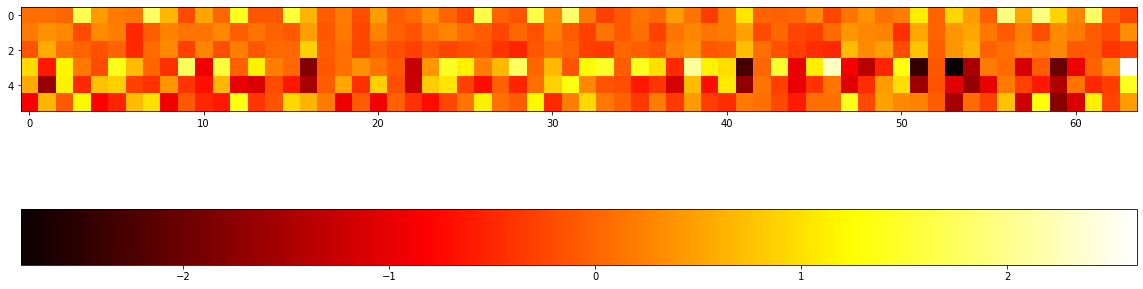

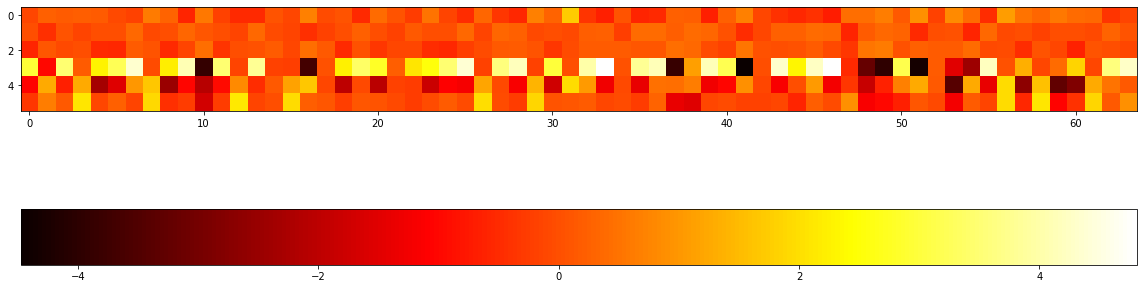

In [214]:
Z = model.get_weights()[0][0]
plt.figure(figsize=(20,12))
im = plt.imshow(Z, cmap='hot')
plt.colorbar(im, orientation='horizontal')
plt.show()

Z = model.get_weights()[0][1]
plt.figure(figsize=(20,12))
im = plt.imshow(Z, cmap='hot')
plt.colorbar(im, orientation='horizontal')
plt.show()

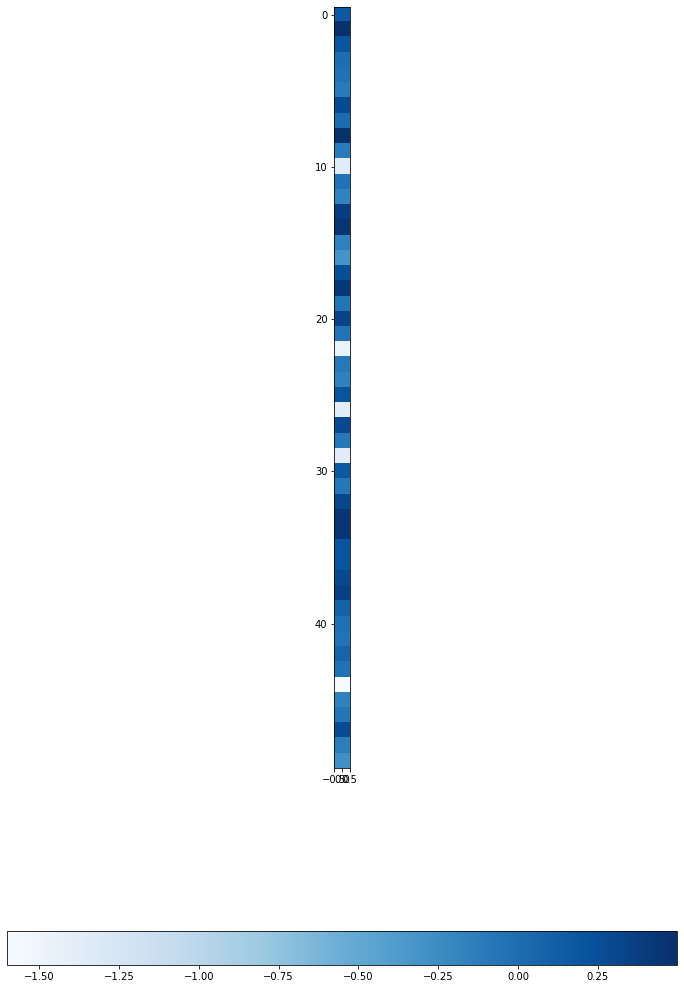

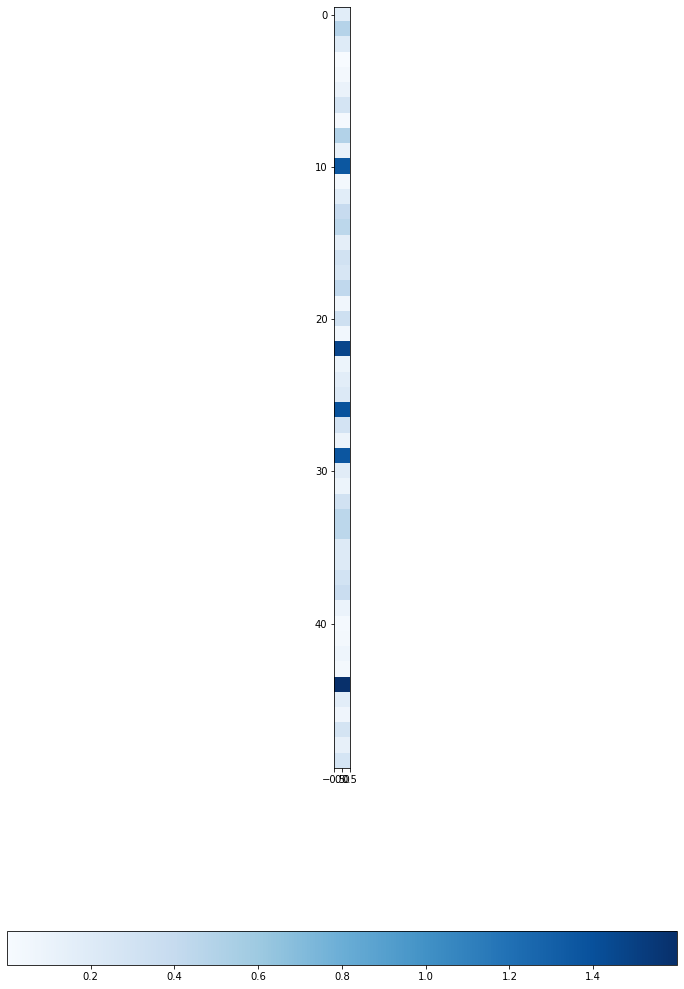

In [215]:
Z = model.get_weights()[4]
plt.figure(figsize=(12,20))
im = plt.imshow(Z, cmap='Blues')
plt.colorbar(im, orientation='horizontal')
plt.show()

Z = np.abs(model.get_weights()[4])
plt.figure(figsize=(12,20))
im = plt.imshow(Z, cmap='Blues')
plt.colorbar(im, orientation='horizontal')
plt.show()

In [216]:
!pip install talos

     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 51 kB 801 kB/s 
     |████████████████████████████████| 9.8 MB 49.1 MB/s 
     |████████████████████████████████| 5.4 MB 38.8 MB/s 
     |████████████████████████████████| 2.6 MB 47.3 MB/s 
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41608 sha256=9b97a95dce6b73eaa6100a0db3526dd6d60f074a54b1f6418161ff4ffdd5aecf
  Stored in directory: /root/.cache/pip/wheels/f3/2e/7e/316f7da11ccf2195ff05e4a0186a4b5975be9bd0b0004198b6
Successfully built chances
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [419]:
class CNNModel():

  def __init__(self, n_steps) -> None:
    self.n_steps = n_steps
    self.pc_train = 0.60
    self.pc_test = 0.2
  
  def split_sequences(self, sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
      # find the end of this pattern
      end_ix = i + n_steps
      # check if we are beyond the dataset
      if end_ix > len(sequences):
        break
      # gather input and output parts of the pattern
      seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
      X.append(seq_x)
      y.append(seq_y)
    return array(X), array(y)

  
  def get_dataset(self):
    # define input sequence
    X_ = df.drop(['Sales','Date'], axis=1).T.to_numpy(copy=True)
    Y_ = df.Sales.to_numpy()

    X_ = np.asarray(X_).astype('float32')
    Y_ = np.asarray(Y_).astype('float32')

    return X_, Y_


  def get_trainset(self):
    X_, Y_ = self.get_dataset()

    in_seq1 = X_[:,:int(self.pc_train*len(df))].T
    out_seq = Y_[:int(self.pc_train*len(df))]
    # convert to [rows, columns] structure
    out_seq = out_seq.reshape((len(out_seq), 1))
    # horizontally stack columns
    dataset = hstack((in_seq1, out_seq))

    # convert into input/output
    X_train_, y_train_ = self.split_sequences(dataset, self.n_steps)

    return X_train_, y_train_


  def get_validationset(self):
    X_, Y_ = self.get_dataset()
    # Define validation set
    in_seq1 = X_[:, int(self.pc_train*len(df)):-int(self.pc_test*len(df))].T
    out_seq = Y_[int(self.pc_train*len(df)):-int(self.pc_test*len(df))]
    # convert to [rows, columns] structure
    out_seq = out_seq.reshape((len(out_seq), 1))
    # horizontally stack columns
    validationset = hstack((in_seq1, out_seq))


    # convert into input/output
    X_val_, y_val_ = self.split_sequences(validationset, self.n_steps)

    return X_val_, y_val_

  def get_testset(self):
    X_, Y_ = self.get_dataset()
    in_seq1 = X_[:, :-int(self.pc_test*len(df))].T
    out_seq = Y_[:-int(self.pc_test*len(df))]
    # convert to [rows, columns] structure
    out_seq = out_seq.reshape((len(out_seq), 1))
    # horizontally stack columns
    testset = hstack((in_seq1, out_seq))

    X_test_, y_test_ = self.split_sequences(testset, self.n_steps)

    return X_test_, y_test_



  def plot_testnet_graphs(self, model):
    
    x_input, y_true = self.get_testset()
    #x_input = x_input.reshape((x_input.shape[0], n_steps, n_features))
    yhat = model.predict(x_input)

    fig = go.Figure()

    fig.update_layout(
        title_text="Prediction on the testset not null sales",
        width=1500,
        height=700
    )

    fig.add_trace(go.Scatter(
        x = df.Date[:-int(self.pc_test*len(df))],
        y=[y for y in y_true if y != 0],
        mode="lines+markers",
        name="Sales",
        textposition="top center"
    ))

    fig.add_trace(go.Scatter(
        x = df.Date[:-int(self.pc_test*len(df))],
        y=[yh[0] for (yh,y) in zip(yhat,y_true) if y != 0],
        mode="lines+markers",
        name="Prediction",
        textposition="top center"
    ))
    fig.show()

    fig = go.Figure()

    fig.update_layout(
        title_text="Prediction on the testset",
        width=1500,
        height=700
    )

    fig.add_trace(go.Scatter(
        x = df.Date[:-int(self.pc_test*len(df))],
        y=y_true,
        mode="lines+markers",
        name="Sales",
        textposition="top center"
    ))

    fig.add_trace(go.Scatter(
        x = df.Date[:-int(self.pc_test*len(df))],
        y=[y[0] for y in yhat],
        mode="lines+markers",
        name="Prediction",
        textposition="top center"
    ))
    fig.show()


    fig = go.Figure()

    fig.update_layout(
        title_text="Prediction error on the testset",
        width=1500,
        height=700
    )

    fig.add_trace(go.Scatter(
        x = df.Date[:-int(self.pc_test*len(df))],
        y=y_true - [y[0] for y in yhat],
        mode="lines+markers",
        name="Eroor",
        textposition="top center"
    ))
    fig.show()

    fig = go.Figure()
    fig.update_layout(
        title_text="Prediction scalled error on the testset",
        width=1500,
        height=700
    )

    fig.add_trace(go.Scatter(
        x = df.Date[:-int(self.pc_test*len(df))],
        y= ( y_true - [y[0] for y in yhat] ) / max(y_true),
        mode="lines+markers",
        name="Scalled Eroor ",
        textposition="top center"
    ))

    avg_pred_scalled_error = np.average(( y_true - [y[0] for y in yhat] ) / max(y_true))
    fig.add_trace(go.Scatter(
        x = df.Date[:-int(self.pc_test*len(df))],
        y= [ avg_pred_scalled_error for i in range(len(y_true))],
        mode="lines+markers",
        name="Averrage scalled Eroor ",
        textposition="top center"
    ))
    fig.show()

In [471]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras_tuner as kt

def get_model(X_, Y_, x_val, y_val, params):

  n_steps = params['n_steps']

  cnnModel_ = CNNModel(n_steps)
  X_train_, y_train_ = cnnModel_.get_trainset()
  X_val_, y_val_ = cnnModel_.get_validationset()


  # Get the number of features
  n_features = X_train_.shape[2]
  # define model
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(params['hidden_dense'], activation='relu'))
  model.add(Dense(1, activation='softplus'))

  model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

  out = model.fit(X_train_, y_train_, validation_data=(X_val_, y_val_), epochs=500,
                  callbacks= (EarlyStopping(monitor="val_root_mean_squared_error", restore_best_weights=True, min_delta=5, patience=20, verbose=1, mode='auto')))

  return  out, model

p = {
  'filters': [int(i) for i in np.linspace(8, 256, 10)],
  'hidden_dense': list(np.arange(1, 100, 10)),
  'n_steps': list(np.arange(3, 30, 2))
}



print(X_.shape, Y_.shape)

scan_object = talos.Scan(X_,
    Y_, 
    params=p,
    model=get_model,
    experiment_name='test_1',
    fraction_limit=.005
  )

# Model created base on  Jason Brownlee model https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/ 

(6, 942) (942,)


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/500
18/18 [==============================] - 1s 20ms/step - loss: 18986042.0000 - root_mean_squared_error: 4357.2974 - val_loss: 13396895.0000 - val_root_mean_squared_error: 3660.1770
Epoch 2/500
18/18 [==============================] - 0s 5ms/step - loss: 7222036.0000 - root_mean_squared_error: 2687.3845 - val_loss: 4403038.5000 - val_root_mean_squared_error: 2098.3418
Epoch 3/500
18/18 [==============================] - 0s 4ms/step - loss: 4112576.5000 - root_mean_squared_error: 2027.9489 - val_loss: 3972246.0000 - val_root_mean_squared_error: 1993.0494
Epoch 4/500
18/18 [==============================] - 0s 5ms/step - loss: 3485863.0000 - root_mean_squared_error: 1867.0466 - val_loss: 3630056.2500 - val_root_mean_squared_error: 1905.2706
Epoch 5/500
18/18 [==============================] - 0s 5ms/step - loss: 3098241.0000 - root_mean_squared_error: 1760.1821 - val_loss: 3276366.5000 - val_root_mean_squared_error: 1810.0736
Epoch 6/500
18/18 [==============================] -

 14%|█▍        | 1/7 [00:15<01:33, 15.58s/it]

Epoch 1/500
18/18 [==============================] - 1s 13ms/step - loss: 17563302.0000 - root_mean_squared_error: 4190.8594 - val_loss: 14645919.0000 - val_root_mean_squared_error: 3826.9988
Epoch 2/500
18/18 [==============================] - 0s 4ms/step - loss: 10670017.0000 - root_mean_squared_error: 3266.4993 - val_loss: 7113073.0000 - val_root_mean_squared_error: 2667.0344
Epoch 3/500
18/18 [==============================] - 0s 5ms/step - loss: 4868076.5000 - root_mean_squared_error: 2206.3718 - val_loss: 4134951.7500 - val_root_mean_squared_error: 2033.4581
Epoch 4/500
18/18 [==============================] - 0s 4ms/step - loss: 4062496.5000 - root_mean_squared_error: 2015.5636 - val_loss: 4040761.7500 - val_root_mean_squared_error: 2010.1646
Epoch 5/500
18/18 [==============================] - 0s 5ms/step - loss: 3855289.0000 - root_mean_squared_error: 1963.4890 - val_loss: 3980885.7500 - val_root_mean_squared_error: 1995.2157
Epoch 6/500
18/18 [==============================] 

 29%|██▊       | 2/7 [00:36<01:33, 18.79s/it]

Epoch 1/500
18/18 [==============================] - 1s 13ms/step - loss: 19166940.0000 - root_mean_squared_error: 4378.0063 - val_loss: 18296272.0000 - val_root_mean_squared_error: 4277.4141
Epoch 2/500
18/18 [==============================] - 0s 4ms/step - loss: 16390039.0000 - root_mean_squared_error: 4048.4614 - val_loss: 15209250.0000 - val_root_mean_squared_error: 3899.9038
Epoch 3/500
18/18 [==============================] - 0s 4ms/step - loss: 13024820.0000 - root_mean_squared_error: 3608.9915 - val_loss: 11267306.0000 - val_root_mean_squared_error: 3356.6809
Epoch 4/500
18/18 [==============================] - 0s 4ms/step - loss: 8957967.0000 - root_mean_squared_error: 2992.9863 - val_loss: 7101900.0000 - val_root_mean_squared_error: 2664.9390
Epoch 5/500
18/18 [==============================] - 0s 4ms/step - loss: 5469494.0000 - root_mean_squared_error: 2338.6948 - val_loss: 4520997.0000 - val_root_mean_squared_error: 2126.2637
Epoch 6/500
18/18 [=============================

 43%|████▎     | 3/7 [00:57<01:19, 19.83s/it]

Epoch 1/500
17/17 [==============================] - 1s 14ms/step - loss: 17262914.0000 - root_mean_squared_error: 4154.8662 - val_loss: 14738564.0000 - val_root_mean_squared_error: 3839.0837
Epoch 2/500
17/17 [==============================] - 0s 5ms/step - loss: 10470850.0000 - root_mean_squared_error: 3235.8694 - val_loss: 7735948.0000 - val_root_mean_squared_error: 2781.3572
Epoch 3/500
17/17 [==============================] - 0s 5ms/step - loss: 5111080.0000 - root_mean_squared_error: 2260.7698 - val_loss: 4550455.0000 - val_root_mean_squared_error: 2133.1794
Epoch 4/500
17/17 [==============================] - 0s 6ms/step - loss: 4083501.7500 - root_mean_squared_error: 2020.7676 - val_loss: 4477159.0000 - val_root_mean_squared_error: 2115.9299
Epoch 5/500
17/17 [==============================] - 0s 6ms/step - loss: 3961604.0000 - root_mean_squared_error: 1990.3778 - val_loss: 4356626.0000 - val_root_mean_squared_error: 2087.2532
Epoch 6/500
17/17 [==============================] 

 57%|█████▋    | 4/7 [01:39<01:25, 28.40s/it]

Epoch 1/500
18/18 [==============================] - 1s 13ms/step - loss: 16408477.0000 - root_mean_squared_error: 4050.7378 - val_loss: 14885573.0000 - val_root_mean_squared_error: 3858.1826
Epoch 2/500
18/18 [==============================] - 0s 4ms/step - loss: 12478922.0000 - root_mean_squared_error: 3532.5518 - val_loss: 10884216.0000 - val_root_mean_squared_error: 3299.1235
Epoch 3/500
18/18 [==============================] - 0s 4ms/step - loss: 8524431.0000 - root_mean_squared_error: 2919.6628 - val_loss: 6973089.0000 - val_root_mean_squared_error: 2640.6606
Epoch 4/500
18/18 [==============================] - 0s 6ms/step - loss: 5380633.5000 - root_mean_squared_error: 2319.6191 - val_loss: 4564252.5000 - val_root_mean_squared_error: 2136.4111
Epoch 5/500
18/18 [==============================] - 0s 5ms/step - loss: 4153564.7500 - root_mean_squared_error: 2038.0297 - val_loss: 4053944.7500 - val_root_mean_squared_error: 2013.4410
Epoch 6/500
18/18 [==============================]

 71%|███████▏  | 5/7 [02:20<01:06, 33.14s/it]

Epoch 1/500
18/18 [==============================] - 1s 13ms/step - loss: 13499910.0000 - root_mean_squared_error: 3674.2224 - val_loss: 8057679.5000 - val_root_mean_squared_error: 2838.6052
Epoch 2/500
18/18 [==============================] - 0s 4ms/step - loss: 5246722.5000 - root_mean_squared_error: 2290.5725 - val_loss: 4428952.0000 - val_root_mean_squared_error: 2104.5076
Epoch 3/500
18/18 [==============================] - 0s 5ms/step - loss: 4349154.0000 - root_mean_squared_error: 2085.4626 - val_loss: 4257793.0000 - val_root_mean_squared_error: 2063.4421
Epoch 4/500
18/18 [==============================] - 0s 5ms/step - loss: 3962684.7500 - root_mean_squared_error: 1990.6493 - val_loss: 4172200.7500 - val_root_mean_squared_error: 2042.5966
Epoch 5/500
18/18 [==============================] - 0s 5ms/step - loss: 3843522.7500 - root_mean_squared_error: 1960.4905 - val_loss: 3989606.2500 - val_root_mean_squared_error: 1997.3999
Epoch 6/500
18/18 [==============================] - 

 86%|████████▌ | 6/7 [02:35<00:27, 27.02s/it]

Epoch 1/500
18/18 [==============================] - 1s 12ms/step - loss: 17097274.0000 - root_mean_squared_error: 4134.8848 - val_loss: 13787215.0000 - val_root_mean_squared_error: 3713.1140
Epoch 2/500
18/18 [==============================] - 0s 5ms/step - loss: 9835490.0000 - root_mean_squared_error: 3136.1584 - val_loss: 6337439.5000 - val_root_mean_squared_error: 2517.4272
Epoch 3/500
18/18 [==============================] - 0s 4ms/step - loss: 4499315.0000 - root_mean_squared_error: 2121.1589 - val_loss: 4297776.0000 - val_root_mean_squared_error: 2073.1079
Epoch 4/500
18/18 [==============================] - 0s 4ms/step - loss: 4058954.5000 - root_mean_squared_error: 2014.6847 - val_loss: 4130770.0000 - val_root_mean_squared_error: 2032.4296
Epoch 5/500
18/18 [==============================] - 0s 5ms/step - loss: 3849938.7500 - root_mean_squared_error: 1962.1261 - val_loss: 4015487.0000 - val_root_mean_squared_error: 2003.8680
Epoch 6/500
18/18 [==============================] -

100%|██████████| 7/7 [02:56<00:00, 25.28s/it]


In [472]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)

In [473]:
analyze_object.data

,start,end,duration,round_epochs,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,filters,hidden_dense,n_steps
0,02/05/22-230815,02/05/22-230830,15.107847,138,95479.945312,308.998291,216553.875000,465.353485,200,91,21
1,02/05/22-230831,02/05/22-230844,13.506463,153,129150.453125,359.375092,168216.265625,410.141754,63,21,13
2,02/05/22-230852,02/05/22-230906,14.591533,170,295136.781250,543.264954,449828.656250,670.692688,228,51,3
3,02/05/22-230913,02/05/22-230937,24.552999,235,155273.656250,394.047791,242893.671875,492.842438,118,11,29
4,02/05/22-230954,02/05/22-231019,24.588827,271,136072.593750,368.880188,229591.687500,479.157257,145,11,7
5,02/05/22-231036,02/05/22-231051,14.749600,145,162679.296875,403.335205,220508.515625,469.583344,173,41,19
6,02/05/22-231051,02/05/22-231105,14.535709,143,139506.984375,373.506348,235464.750000,485.247101,145,21,19


In [474]:
!rm -r best_model_step_1_test

In [475]:
talos.Deploy(scan_object=scan_object, model_name='best_model_step_1_test', metric='val_root_mean_squared_error', asc=True);

Deploy package best_model_step_1_test have been saved.


In [476]:
restore = talos.Restore('best_model_step_1_test.zip')

In [477]:
model_n_steps = restore.results.sort_values(by=['val_root_mean_squared_error'])['n_steps'].iloc[0]
model_n_steps

13

In [478]:
cnnModel_ = CNNModel(model_n_steps)
# convert into input/output
X_train_ , y_train_ = cnnModel_.get_trainset()
X_val_, y_val_ = cnnModel_.get_validationset()

In [479]:
from sklearn.metrics import mean_squared_error
y_pred = restore.model.predict(X_val_)
mean_squared_error(y_val_, y_pred, squared=False)

409.6184

In [480]:
model = restore.model
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.fit(X_train_, y_train_, validation_data=(X_val_, y_val_), epochs=500,
                  callbacks= (EarlyStopping(monitor="val_root_mean_squared_error", restore_best_weights=True, min_delta=5, patience=50, verbose=1, mode='auto')))


Epoch 1/500
18/18 [==============================] - 1s 13ms/step - loss: 156643.0938 - root_mean_squared_error: 395.7816 - val_loss: 165819.7344 - val_root_mean_squared_error: 407.2097
Epoch 2/500
18/18 [==============================] - 0s 4ms/step - loss: 139930.6250 - root_mean_squared_error: 374.0730 - val_loss: 166334.7656 - val_root_mean_squared_error: 407.8416
Epoch 3/500
18/18 [==============================] - 0s 5ms/step - loss: 135786.4062 - root_mean_squared_error: 368.4921 - val_loss: 166010.2344 - val_root_mean_squared_error: 407.4435
Epoch 4/500
18/18 [==============================] - 0s 4ms/step - loss: 138748.7031 - root_mean_squared_error: 372.4899 - val_loss: 177019.0781 - val_root_mean_squared_error: 420.7364
Epoch 5/500
18/18 [==============================] - 0s 5ms/step - loss: 148728.3281 - root_mean_squared_error: 385.6531 - val_loss: 172499.3906 - val_root_mean_squared_error: 415.3304
Epoch 6/500
18/18 [==============================] - 0s 5ms/step - loss: 1

In [481]:
import plotly.graph_objects as go



CNNModel(n_steps = model_n_steps).plot_testnet_graphs(model)